# Listening Procedure

This Jupyter notebook loads both models as well as a validation dataset for testing.

At a later stage, I will add the data preprocessing script to allow us to create textual data directly, should be pretty straight forward.

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import librosa
import lws
import matplotlib.pyplot as plt
from IPython.display import Audio

from networks import SSRN, Text2Mel
from hparams import Hparams

%matplotlib inline

# set up parameters for creating wav from mel spectrogram
rate = 22050
eta = 1.3
gamma = 0.6

# load model and text data
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
# create models and load
hp = Hparams()
text2mel = Text2Mel(hp, device)
ssrn = SSRN(hp, device)

text2mel.load_state_dict(torch.load("save_stuff/text2mel/checkpoint/epoch_0_text2mel_model.pt"))
ssrn.load_state_dict(torch.load("save_stuff/ssrn/checkpoint/epoch_270_ssrn_model.pt"))

# load validation text
text = np.load("../../ETTT/Pytorch-DCTTS/LJSpeech_val/LJ001-0050_txt.npy")
mel_target = np.load("../../ETTT/Pytorch-DCTTS/LJSpeech_val/LJ001-0050_mel.npy")
fft_target = np.load("../../ETTT/Pytorch-DCTTS/LJSpeech_val/LJ001-0050_fft.npy")

# load to data to torch
text = torch.from_numpy(text).long().unsqueeze(0)
mel_target = torch.from_numpy(mel_target).unsqueeze(0)
fft_target = torch.from_numpy(fft_target).unsqueeze(0)

# create initial mel_input
mel_in = torch.zeros(1,80,1)

T = mel_target.shape[-1]

# run our text2mel network forward
with torch.no_grad():
    for i in range(T):
        y, _, a = text2mel.forward(text, mel_in)
        # update mel_in
        mel_in = torch.cat((mel_in, y[:,:,-1].view(1,80,1)), dim=-1)
        
    # use our ssrn network to get the t output prediction
    our_pred,_ = ssrn.forward(y)

In [6]:
with torch.no_grad():
    # load y directly
    y = np.load("../../ETTT/Pytorch-DCTTS/save_stuff/my_prediction.npy")
    y = torch.from_numpy(y)
    our_pred,_ = ssrn.forward(y)
    y.shape

attention
prediction plot
actual plot
predict fft


RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

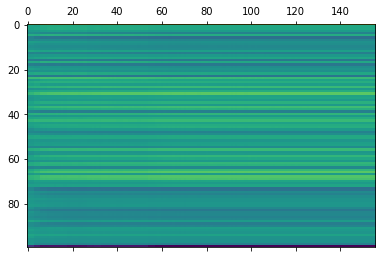

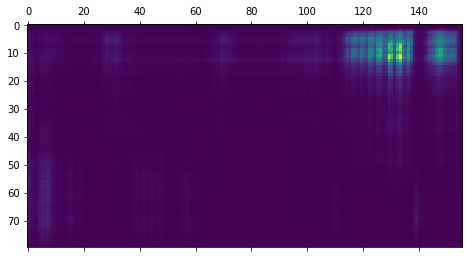

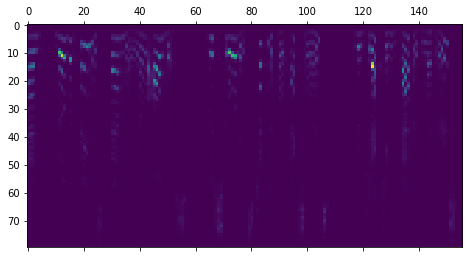

In [8]:
print("attention")
plt.matshow(a[0])
print("prediction plot")
plt.matshow(y[0])
print("actual plot")
plt.matshow(mel_target[0])
print("predict fft")
plt.matshow(our_pred[0])
plt.matshow(fft_target[0])

l1_loss = F.l1_loss(y, mel_target)
print(l1_loss.numpy())

# Ground-Truth Sample

In [3]:
# load our ground truth data and listen
t = fft_target.numpy()
# lastly convert our voice prediction to wav via lws
t = t[0].astype(np.float64)
t[t<0] = 0
t = t ** (eta / gamma) * 50
t = np.transpose(t, (1, 0))
lws_processor=lws.lws(1024, 256, mode='speech', fftsize=1024)
t = lws_processor.run_lws(t)
t = lws_processor.istft(t)
Audio(t, rate=rate)

In [4]:
our_pred

tensor([[[ 0.0027,  0.0024,  0.0018,  ...,  0.0033,  0.0030,  0.0034],
         [ 0.0032,  0.0030,  0.0023,  ...,  0.0041,  0.0038,  0.0044],
         [ 0.0054,  0.0056,  0.0045,  ...,  0.0067,  0.0064,  0.0070],
         ...,
         [ 0.0007,  0.0008,  0.0006,  ...,  0.0013,  0.0014,  0.0011],
         [ 0.0007,  0.0008,  0.0005,  ...,  0.0011,  0.0012,  0.0010],
         [ 0.0006,  0.0007,  0.0005,  ...,  0.0010,  0.0011,  0.0008]]])

# Generated Sample

In [7]:
# load our ground truth data and listen
t = our_pred.numpy()
# lastly convert our voice prediction to wav via lws
t = t[0].astype(np.float64)
t[t<0] = 0
t = t ** (eta / gamma) * 50
t = np.transpose(t, (1, 0))
lws_processor=lws.lws(1024, 256, mode='speech', fftsize=1024)
t = lws_processor.run_lws(t)
t = lws_processor.istft(t)
Audio(t, rate=rate)